### PROJET N° 7 - Implémenter un modèle de scoring

Auteur : Florian FOLLAIN
Date : Fevrier 2024

Plan

* [1 Importation des bibliothèques ](#chapter1)
* [2 Création fonction mêtier ](#chapter2)
* [3 Traitement des données désequilibrées ](#chapter3)
* [4 Création et séléction du modèle ](#chapter4)
* [5 Visualisation de l'influence des variables ](#chapter5)

#### <span style="color:blue">1 Importation des bibliothèques<a class="anchor" id="chapter1"></a></span>    

In [1]:
import numpy as np
import pandas as pd
import psutil
import os

from collections import Counter
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import joblib

#Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [2]:
def print_memory_usage():
    """
    Cette fonction permet de mesurer la quantité de memoire ram utilisée
    """
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0]/(2.**30)
    print(f'mémoire RAM utilisée: {memory_use:.2f} GB')

In [3]:
train_df = pd.read_csv(r'C:\P7_git\data_api\train_df.csv')
test_df = pd.read_csv(r'C:\P7_git\data_api\test_df.csv')

In [4]:

test_api = test_df.sample(n=1000, replace=True)
test_api.to_csv('test_api.csv')

In [5]:
train_df.head()

,Unnamed: 0,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cashloans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Industrytype2

#### <span style="color:blue">2 Création fonction mêtier<a class="anchor" id="chapter2"></a></span>

In [6]:
#Création score métier 
def custom_metric(y_true, y_pred):
    """Fonction qui extraie de la matrice de confusion les
    valeurs des 4 mesures et retourne un calcul sur base
    d'une pondération de FP et FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel().tolist()
    score=(10*fn + fp)/len(y_true)
    return score
score_metier=make_scorer(custom_metric, greater_is_better=False)

scoring = {"AUC": "roc_auc", "score_metier": score_metier}

#### Comme dans l'énoncé il est spécifié qu'un faux négatif, c'est à dire un crédit validé alors qu'il est à risque, coûte 10 fois plus cher à la banque qu'un faux positf, un crédit refusé pour cause de risque alors que le risque n'est pas avéré, j'ai créé une fonction de coût très simple qui reprend ce principe en pénalisant 10 fois plus un faux négatif dans les calculs d'entrainement de mon modèle

In [7]:
TRAIN_SIZE = 0.8
RANDOM_STATE = 42
X = train_df.drop('TARGET', axis=1)
y = train_df['TARGET']
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [8]:
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### <span style="color:blue">3 Traitement des données désequilibrées<a class="anchor" id="chapter3"></a></span>

In [9]:
y_train_counter = Counter(y_train)
print("Training target stats", y_train_counter)
print("Testing target stats", Counter(y_test))
#ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target stats Counter({0.0: 226201, 1.0: 19804})
Testing target stats Counter({0.0: 56481, 1.0: 5021})
Ratio is 1:11


#### Les données sont désequilibrées, la catégorie 1 est 11 fois moins représentée, pour entrainer le modèle je vais devoir rééquilibrer les données

In [10]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
# steps = [('over', over)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))


Training target statistics: Counter({0.0: 113100, 1.0: 113100})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})


#### Pour rééquilibrer les données avec la librairie SMOTE, j'ai reduis de moitié la catégorie 0 et multiplier les données de 1 jusqu'au niveau de 0, ainsi les données sont égales dans chacune des catégories. En revanche ce rééquilibrage des données ne s'applique pas aux données de test

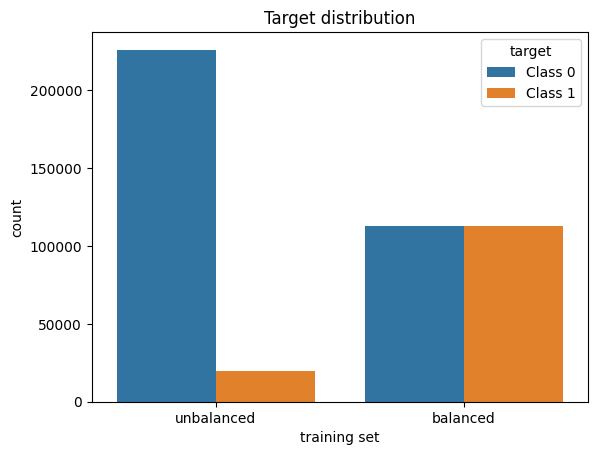

In [11]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title("Target distribution")
plt.show()

In [12]:
def plot_sklearn_roc_curve(y_real, y_pred):
    """
    Cette fonction permet d'afficher la courbe roc d'un modèle de classification
    """
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

#### <span style="color:blue">4 Création et sélection du modèle <a class="anchor" id="chapter4"></a></span>

In [14]:
def find_best_model_using_gridsearchcv(x_res,y_res):
    """
    Cette fonction test tous les algorithmes listés et renvoi leur scores par metric visuellement
    """
    algos = { 
    #----------- 'Dummy'--------------- 
        'Dummy':{
            'model': Pipeline([
         ('scaler',StandardScaler()),
         ('dummy',DummyClassifier())
    ]),
            'params': {
                'dummy__strategy': ['most_frequent',
                                    'stratified'] }
            },
        
    #-------------"LogisiticRegression"-----------
        
        'LogisiticRegression':{
            'model': Pipeline([
         ('scaler',StandardScaler()),
         ('Logreg',LogisticRegression(solver='lbfgs',
             class_weight='balanced', 
                                      max_iter=10000
         ))
    ]),
            'params': {
                'Logreg__penalty': ['l2'],
                'Logreg__C': [100,1000]
            }
            },
     #------------"DecisionTree Classifier"---------- 
        
        
        'DecisionTree Classifier':{
            'model': Pipeline([
         ('scaler',StandardScaler()),
         ('DecisionTree',DecisionTreeClassifier())
    ]),
            'params': {
                'DecisionTree__criterion': ["gini", "entropy"],
                'DecisionTree__min_samples_leaf': list(range(5,7,1)),
                "DecisionTree__max_depth": list(range(2,4,1))
            }
            },
        
     #------------"LGBMClassifier"---------- 
        "LGBMClassifier": {
            'model': Pipeline([
         ('scaler',StandardScaler()),
         ('LGBMC',LGBMClassifier())
    ]),
            'params': {
            'LGBMC__subsample': [0.5, 0.75],
            'LGBMC__reg_lambda': [ 1, 2],
            'LGBMC__colsample_bytree': [ 0.97, 0.99]
            
            }
        },
        
         #------------'CatBoostClassifier'----------  
        'CatBoostClassifier': {
            'model': Pipeline([
         ('scaler',StandardScaler()),
         ('CatBoost',CatBoostClassifier(logging_level='Silent'))]),
            'params': {
            'CatBoost__max_depth': [3,4,6],
            'CatBoost__n_estimators':[100, 200, 300],
           }
            }

    }
    
    scores = []
    best_score = float('inf')  # Initialisez pour le meilleur score (inf pour s'assurer qu'il sera remplacé)
    second_best_score = float('inf')  # De même pour le deuxième meilleur score
    best_model = None
    second_best_model = None
    best_params = None
    second_best_params = None
    model_name = ''
    second_model_name = ''
    cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=45)
    for algo_name, config in algos.items():
        
        gs =  GridSearchCV(config['model'], 
                           config['params'],
                           cv=cv,
                           scoring=scoring,
                           refit="AUC",
                           verbose=1,
                           return_train_score=True)
        gs.fit(x_res, y_res)
        gs.best_estimator_[1]
        
        # Predict the classes on the test data
        y_pred= gs.best_estimator_.predict(x_res)
        # Predict the classes on the test data, 
        #and return the probabilities for each class
        y_proba=gs.best_estimator_.predict_proba(x_res)
        y_test_proba=gs.best_estimator_.predict_proba(x_test)
        score_metier=custom_metric(y_res, y_pred)
        gs.score(x_test, y_test)
        print('--------------',algo_name,'-------------')
        print('Best params: ',algo_name,gs.best_params_)
        print('Score_metier ',score_metier)
        print('score_AUC_train ',roc_auc_score(y_res, y_proba[:, 1]))
        print('score_AUC_test ',roc_auc_score(y_test, y_test_proba[:, 1]))
        
        #saving the best model 
        if score_metier < best_score:
            # Déplacez le deuxième meilleur au lieu de le remplacer directement
            second_best_score = best_score
            second_best_model = best_model
            second_best_params = best_params
            second_model_name = model_name
        
            # Mettez à jour le meilleur modèle
            best_score = score_metier
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            model_name = algo_name
        elif score_metier < second_best_score and score_metier != best_score:
            # Mettez à jour le deuxième meilleur modèle si le score actuel est meilleur que le deuxième meilleur score
            # mais pas meilleur que le meilleur score
            second_best_score = score_metier
            second_best_model = gs.best_estimator_
            second_best_params = gs.best_params_
            second_model_name = algo_name

        # À la fin de la boucle, vous avez maintenant à la fois le meilleur et le deuxième meilleur modèle
        # Sauvegardez le meilleur modèle comme avant
        joblib.dump(best_model, 'best_model.joblib')

        # Sauvegardez également le deuxième meilleur modèle
        joblib.dump(second_best_model, 'second_best_model.joblib')
        #Time
        mean_fit_time= gs.cv_results_['mean_fit_time']
        mean_score_time= gs.cv_results_['mean_score_time']
        n_splits  = gs.n_splits_ #number of splits of training data
        n_iter = pd.DataFrame(gs.cv_results_).shape[0] #Iterations par split
        
#------------Matrice de confusion--------------      
        plt.figure(figsize =(4, 4))
        cm = confusion_matrix(y_res, y_pred)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(
            group_names, group_counts, group_percentages)]
        labels= np.asarray(labels).reshape(2, 2)
        categories = ['0', '1']
        sns.heatmap(cm, annot=labels,  fmt='',
                    cmap='Blues')
        plt.ylabel('classe réelle')
        plt.xlabel('classe estimée')
        plt.title('Matrice de confusion '+algo_name,
                fontsize = 10,)
        plt.show()
        print(classification_report(y_res, y_pred))
        
#-------------Roc_curve---------------
        plt.figure(figsize =(4, 4))
        plot_sklearn_roc_curve(y_res, y_proba[:, 1])
        plt.title('Roc_curve '+algo_name,
                fontsize = 10)
        plt.show()
#------------métriques-------------
        scores.append({
            'Model':algo_name,
            'AUC_train' : roc_auc_score(y_res, y_proba[:, 1]),
            'AUC_test': roc_auc_score(y_test, y_test_proba[:, 1]),
            'Score_metier':custom_metric(y_res, y_pred),
            'Time_min':((np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)/60)
            })
        
        
    results= pd.DataFrame(scores,columns=['Model','AUC_train','AUC_test','Score_metier','Time_min'])
          
    plt.figure(figsize=(10,6))
    plt.title('Comparaison des scores metiers ')
    sns.barplot(y = results['Model'],x= results['Score_metier'])
    plt.show()
        
    plt.figure(figsize=(10,6))
    plt.title('Comparaison des AUC')
    sns.barplot(y = results['Model'],x= results['AUC_train'])
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.title("Comparaison des temps d'entrainement")
    sns.barplot(y = results['Model'],x= results['Time_min'])
    plt.show()
    
    results.head()
        
       
    return {
    "best_model_name": model_name,
    'best_score': best_score,
    'best_params': best_params,
    "second_best_model_name": second_model_name,
    'second_best_score': second_best_score,
    'second_best_params': second_best_params
    }

#### J'ai gardé les 2 meilleures scores parceque les performances entre catboost et LgbmClassifier sont assez proches et même si CatBoost est légerement plus performant, j'ai pensé qu'à l'usage, pour le CGP, il sera plus significatif d'avoir des variables numériques à présenter à son client pour jusutifier de leur influence sur le score plutôt que des varables catégorielles

Fitting 5 folds for each of 2 candidates, totalling 10 fits
-------------- Dummy -------------
Best params:  Dummy {'dummy__strategy': 'most_frequent'}
Score_metier  5.0
score_AUC_train  0.5
score_AUC_test  0.5


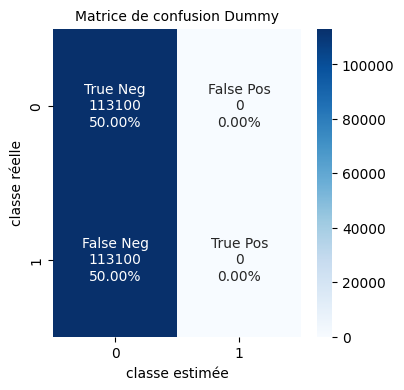

C:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67    113100
         1.0       0.00      0.00      0.00    113100

    accuracy                           0.50    226200
   macro avg       0.25      0.50      0.33    226200
weighted avg       0.25      0.50      0.33    226200



C:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 400x400 with 0 Axes>

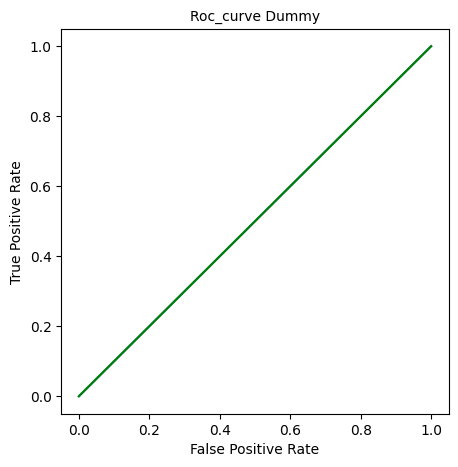

Fitting 5 folds for each of 2 candidates, totalling 10 fits
-------------- LogisiticRegression -------------
Best params:  LogisiticRegression {'Logreg__C': 1000, 'Logreg__penalty': 'l2'}
Score_metier  1.435711759504863
score_AUC_train  0.797821240797679
score_AUC_test  0.7706455323504666


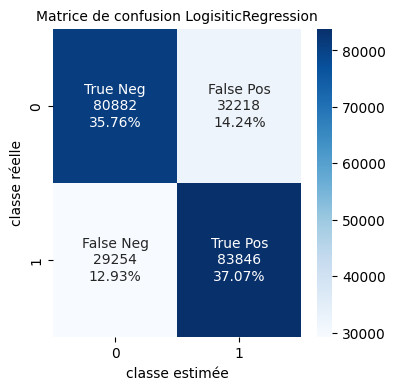

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72    113100
         1.0       0.72      0.74      0.73    113100

    accuracy                           0.73    226200
   macro avg       0.73      0.73      0.73    226200
weighted avg       0.73      0.73      0.73    226200



<Figure size 400x400 with 0 Axes>

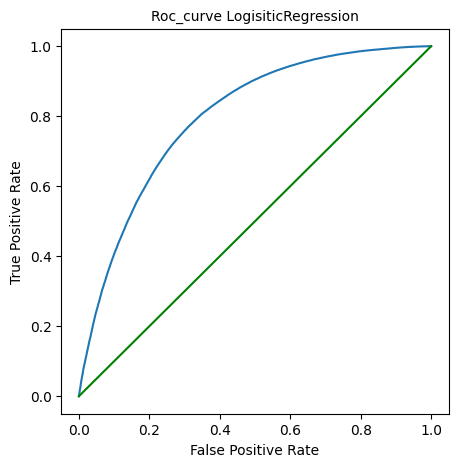

Fitting 5 folds for each of 8 candidates, totalling 40 fits
-------------- DecisionTree Classifier -------------
Best params:  DecisionTree Classifier {'DecisionTree__criterion': 'entropy', 'DecisionTree__max_depth': 3, 'DecisionTree__min_samples_leaf': 5}
Score_metier  1.647316534040672
score_AUC_train  0.8113361392741024
score_AUC_test  0.6299001903448304


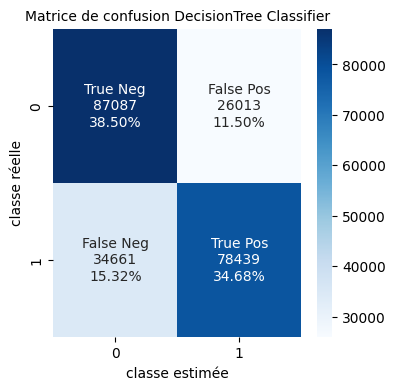

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74    113100
         1.0       0.75      0.69      0.72    113100

    accuracy                           0.73    226200
   macro avg       0.73      0.73      0.73    226200
weighted avg       0.73      0.73      0.73    226200



<Figure size 400x400 with 0 Axes>

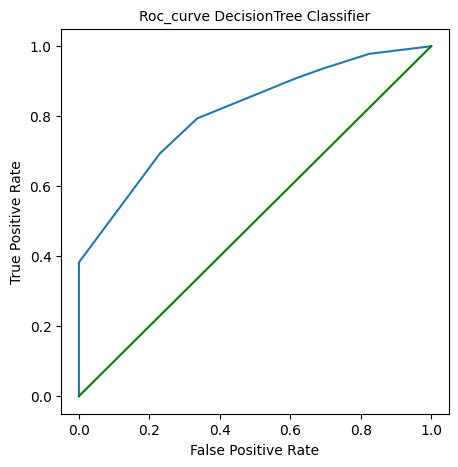

Fitting 5 folds for each of 8 candidates, totalling 40 fits
-------------- LGBMClassifier -------------
Best params:  LGBMClassifier {'LGBMC__colsample_bytree': 0.99, 'LGBMC__reg_lambda': 2, 'LGBMC__subsample': 0.5}
Score_metier  0.7519451812555261
score_AUC_train  0.9669138149146197
score_AUC_test  0.7757766030888252


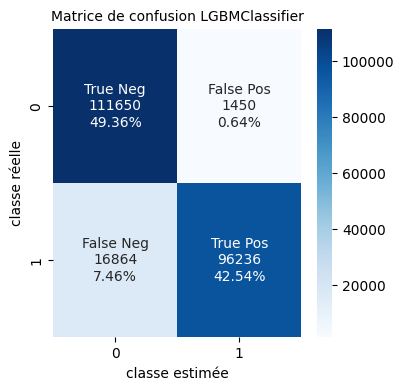

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92    113100
         1.0       0.99      0.85      0.91    113100

    accuracy                           0.92    226200
   macro avg       0.93      0.92      0.92    226200
weighted avg       0.93      0.92      0.92    226200



<Figure size 400x400 with 0 Axes>

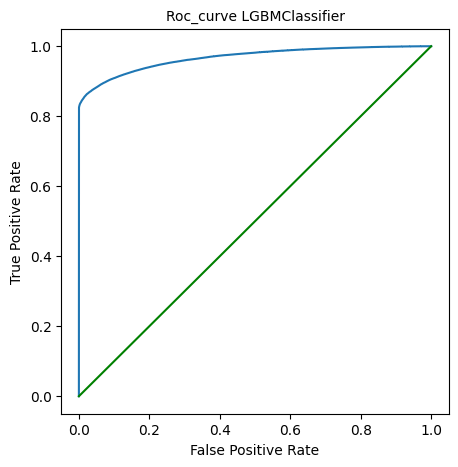

Fitting 5 folds for each of 9 candidates, totalling 45 fits
-------------- CatBoostClassifier -------------
Best params:  CatBoostClassifier {'CatBoost__max_depth': 3, 'CatBoost__n_estimators': 300}
Score_metier  0.7315915119363395
score_AUC_train  0.96623771120289
score_AUC_test  0.7767554560888706


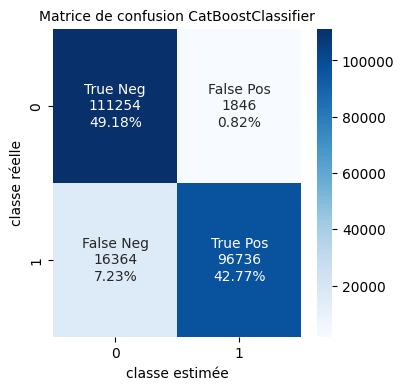

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92    113100
         1.0       0.98      0.86      0.91    113100

    accuracy                           0.92    226200
   macro avg       0.93      0.92      0.92    226200
weighted avg       0.93      0.92      0.92    226200



<Figure size 400x400 with 0 Axes>

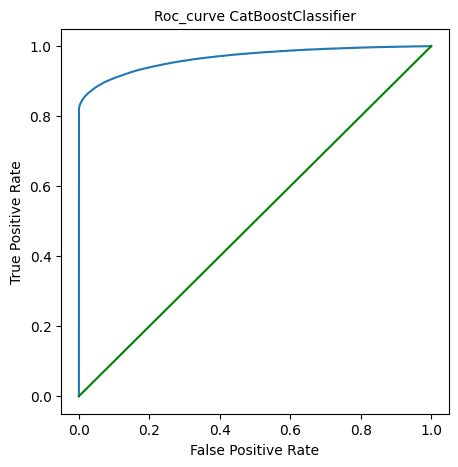

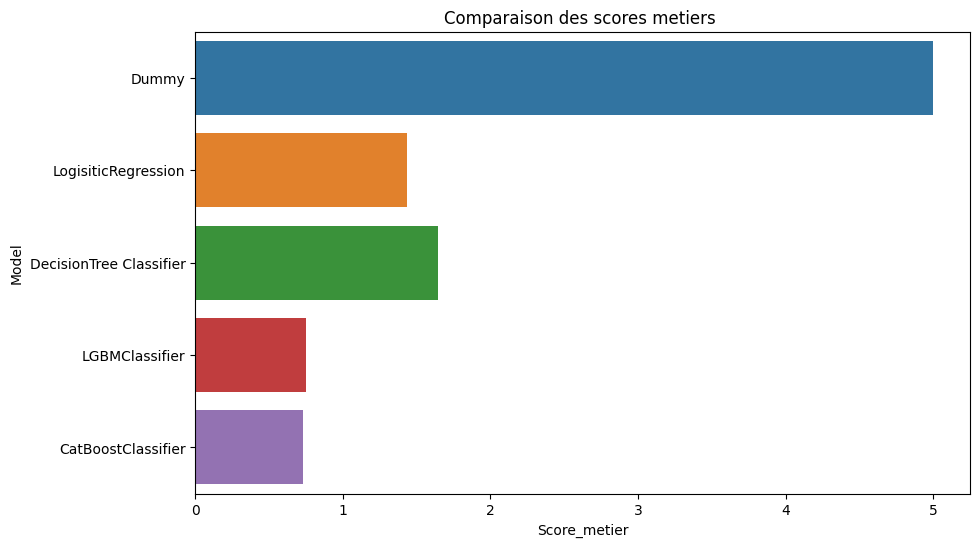

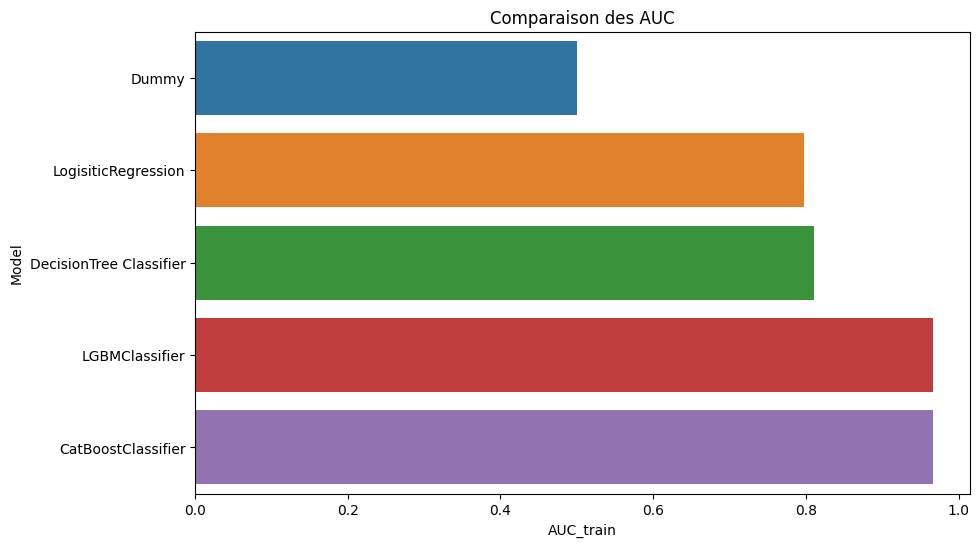

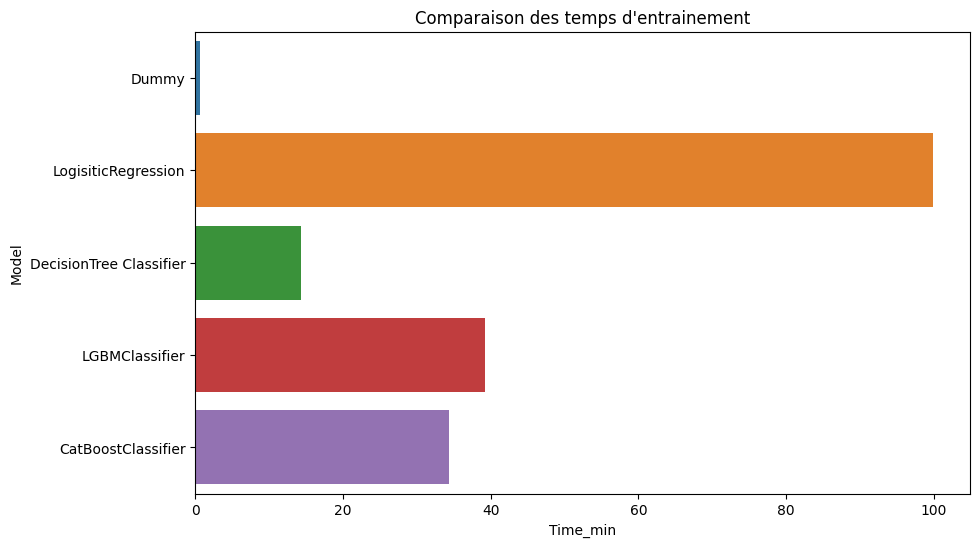

{'best_model_name': 'CatBoostClassifier',
 'best_score': 0.7315915119363395,
 'best_params': {'CatBoost__max_depth': 3, 'CatBoost__n_estimators': 300},
 'second_best_model_name': 'LGBMClassifier',
 'second_best_score': 0.7519451812555261,
 'second_best_params': {'LGBMC__colsample_bytree': 0.99,
  'LGBMC__reg_lambda': 2,
  'LGBMC__subsample': 0.5}}

In [15]:
find_best_model_using_gridsearchcv(x_res,y_res)

In [16]:
loaded_model = joblib.load('best_model.joblib')
loaded_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('CatBoost',
                 <catboost.core.CatBoostClassifier object at 0x000001D50EE1FB90>)])

In [17]:
print('RAM memory % used:', psutil.virtual_memory()[2])
print_memory_usage()

#search best thersholds

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    """
    Cette fonction permet de trouver le seuil optimal qui maximise l'aire sous la courbe ROC (AUC) pour un modèle de classification donné
    """
    return (pos_probs >= threshold).astype('int')
# predict probabilities
y_pred= loaded_model.predict(x_res)
y_proba=loaded_model.predict_proba(x_res)
# keep probabilities for the positive outcome only
probs = y_proba[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold

scores = [roc_auc_score(y_res, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
thresh=thresholds[ix]
print('Threshold=%.3f ' %thresholds[ix], 'score=%.5f' %scores[ix])
joblib.dump(thresh, 'thresh.joblib')

RAM memory % used: 67.7
mémoire RAM utilisée: 1.61 GB
Threshold=0.470  score=0.91985


['thresh.joblib']

#### Les seuil optimal pour passer de la catégorie  à  est 0.47

In [18]:
import shap
# load JS visualization code to notebook
shap.initjs()

In [19]:
print(loaded_model.named_steps)

{'scaler': StandardScaler(), 'CatBoost': <catboost.core.CatBoostClassifier object at 0x000001D50EE1FB90>}


#### <span style="color:blue">5 Visulaisation de l'influence des variables<a class="anchor" id="chapter5"></a></span>

In [20]:
from catboost import Pool
pool = Pool(data=x_test)
shap_values = loaded_model['CatBoost'].get_feature_importance(data=pool, type='ShapValues')
shap_values_without_expected_value = shap_values[:, :-1]

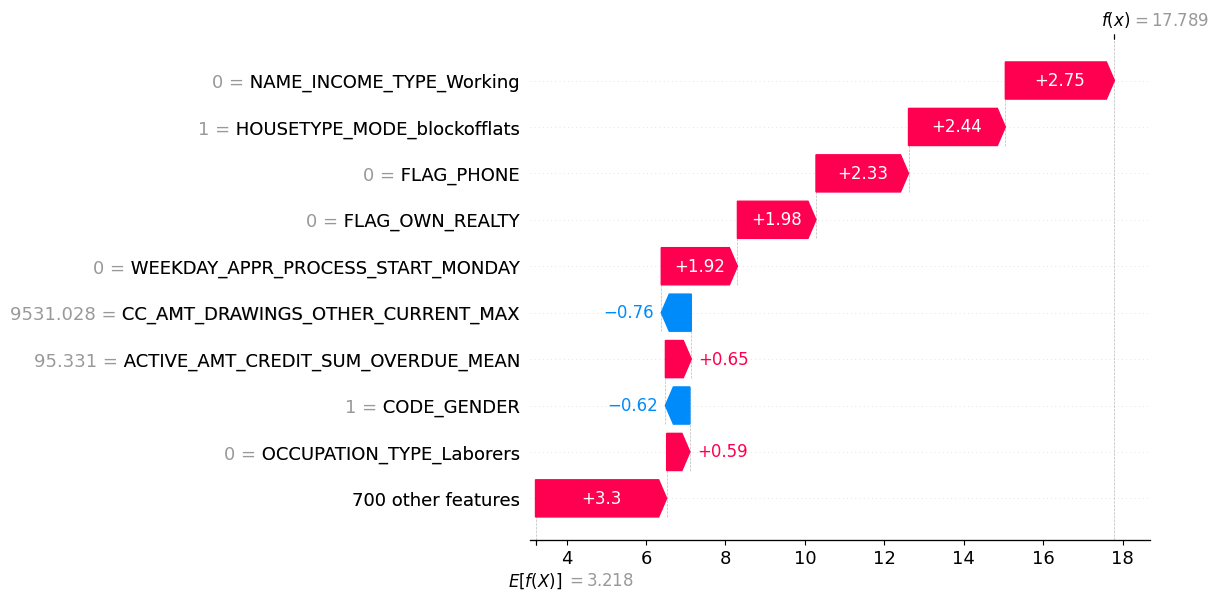

In [21]:
shap.waterfall_plot(shap.Explanation(values=shap_values_without_expected_value[0],
                                     base_values=shap_values[0, -1],
                                     data=x_test.iloc[0],
                                     feature_names=x_test.columns.tolist()))

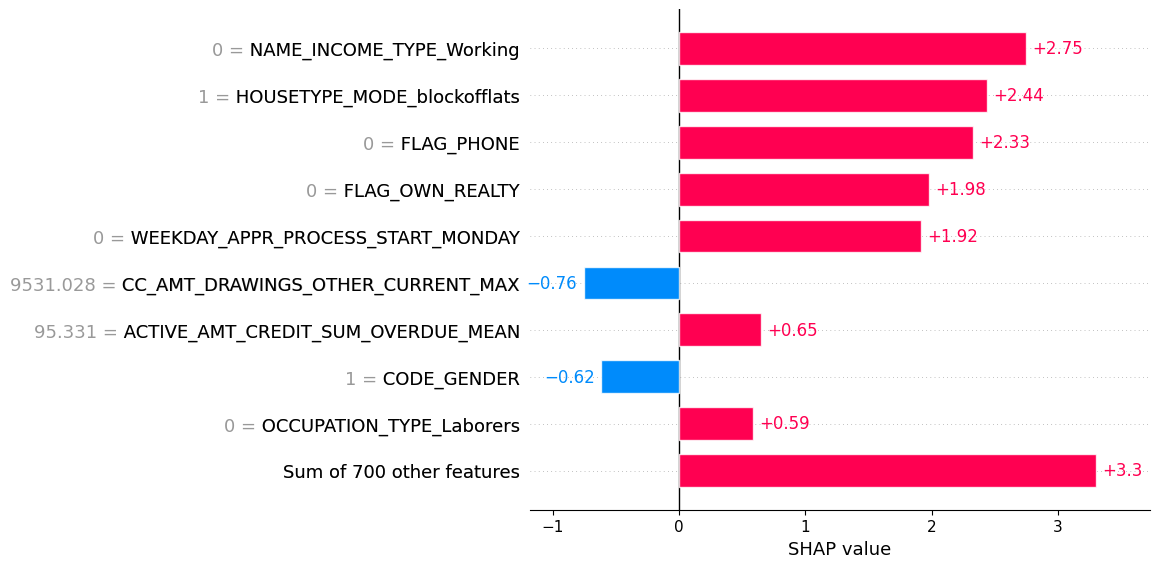

In [22]:
shap.plots.bar(shap.Explanation(values=shap_values_without_expected_value[0],
                                     base_values=shap_values[0,-1],
                                     data=x_test.iloc[0],
                                     feature_names=x_test.columns.tolist()))

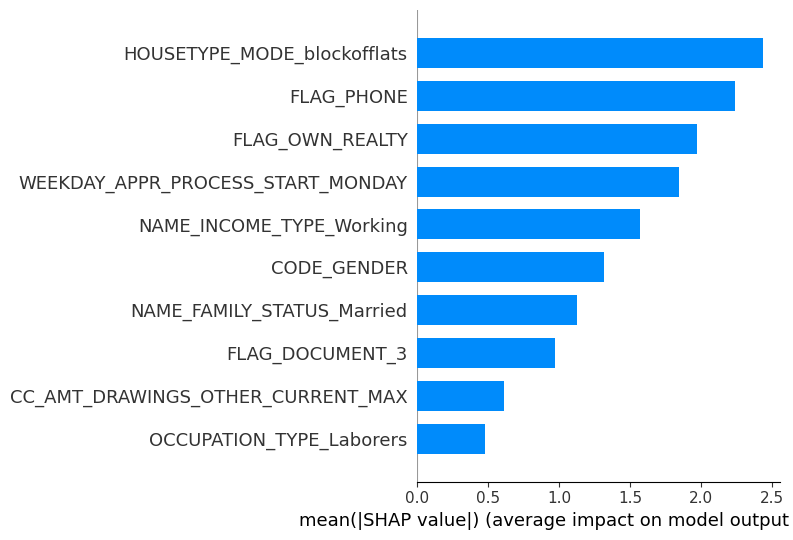

In [23]:
shap.summary_plot(shap_values_without_expected_value, x_test, plot_type='bar', max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


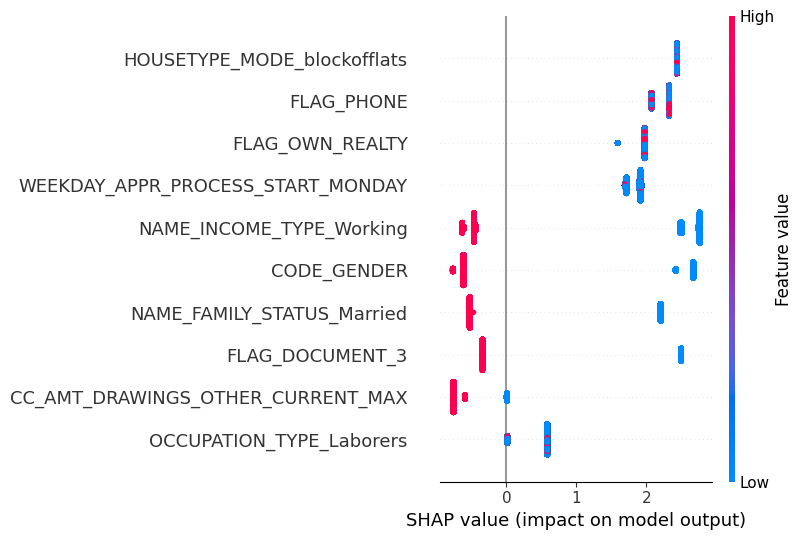

In [24]:
feature_names=x_test.columns.tolist()
shap.summary_plot(shap_values_without_expected_value, x_test, feature_names=feature_names, max_display=10)

In [25]:
#description des variables 
path = "/cygwin64/openclassrooms/Projet_7/data"
des=pd.read_csv(path + '/HomeCredit_columns_description.csv',encoding='latin1')
des.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [26]:
liste=['NAME_INCOME_TYPE'
       'FLAG_OWN_CAR',
       'EMERGENCYSTATE_MODE',
       'REG_CITY_NOT_WORK_CITY',
       'FLAG_PHONE',
       'WEEKDAY_APPR_PROCESS_START',
       'FLAG_OWN_REALTY',
       'CODE_GENDER'
      ]

In [ ]:
result=des[des['Row'].isin(liste)]
result.head()
pd.set_option('display.max_colwidth',None)
result[['Row','Description']]